# Experimental Data (Testing)

In [2]:
base='C:/Users/marcb/Downloads/OneDrive_1_4-17-2024/FR_1ulh_20X_25fps_1x1y_5min_001_frames/'
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
files=os.listdir(base)

In [3]:
full_files=[]
sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
for i in range(len(sorted_frames)):
    file = base+sorted_frames[i]
    full_files.append(file)

In [14]:
import cv2
import numpy as np
import cv2
from joblib import Parallel, delayed

def process_file(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, [384, 384])
    return resized_image

def parallel_image_processing(full_files):
    num_files = len(full_files)
    images = np.zeros([num_files, 384, 384])

    results = Parallel(n_jobs=16)(delayed(process_file)(file_path) for file_path in full_files)

    for i, resized_image in enumerate(results):
        images[i] = resized_image

    return images

images = parallel_image_processing(full_files)

In [15]:
import gc
gc.collect()

26

In [16]:
k=10
for i in range(k+1,len(images)):
    tst=images[i]/255-images[i-k]/255
    tst[tst<0]=0
    tst=(tst-np.min(tst))/(np.max(tst)-np.min(tst))
#im_for = (im_for-np.min(im_for))/(np.max(im_for)-np.min(im_for))
    images[i-k]=1-tst
    
    

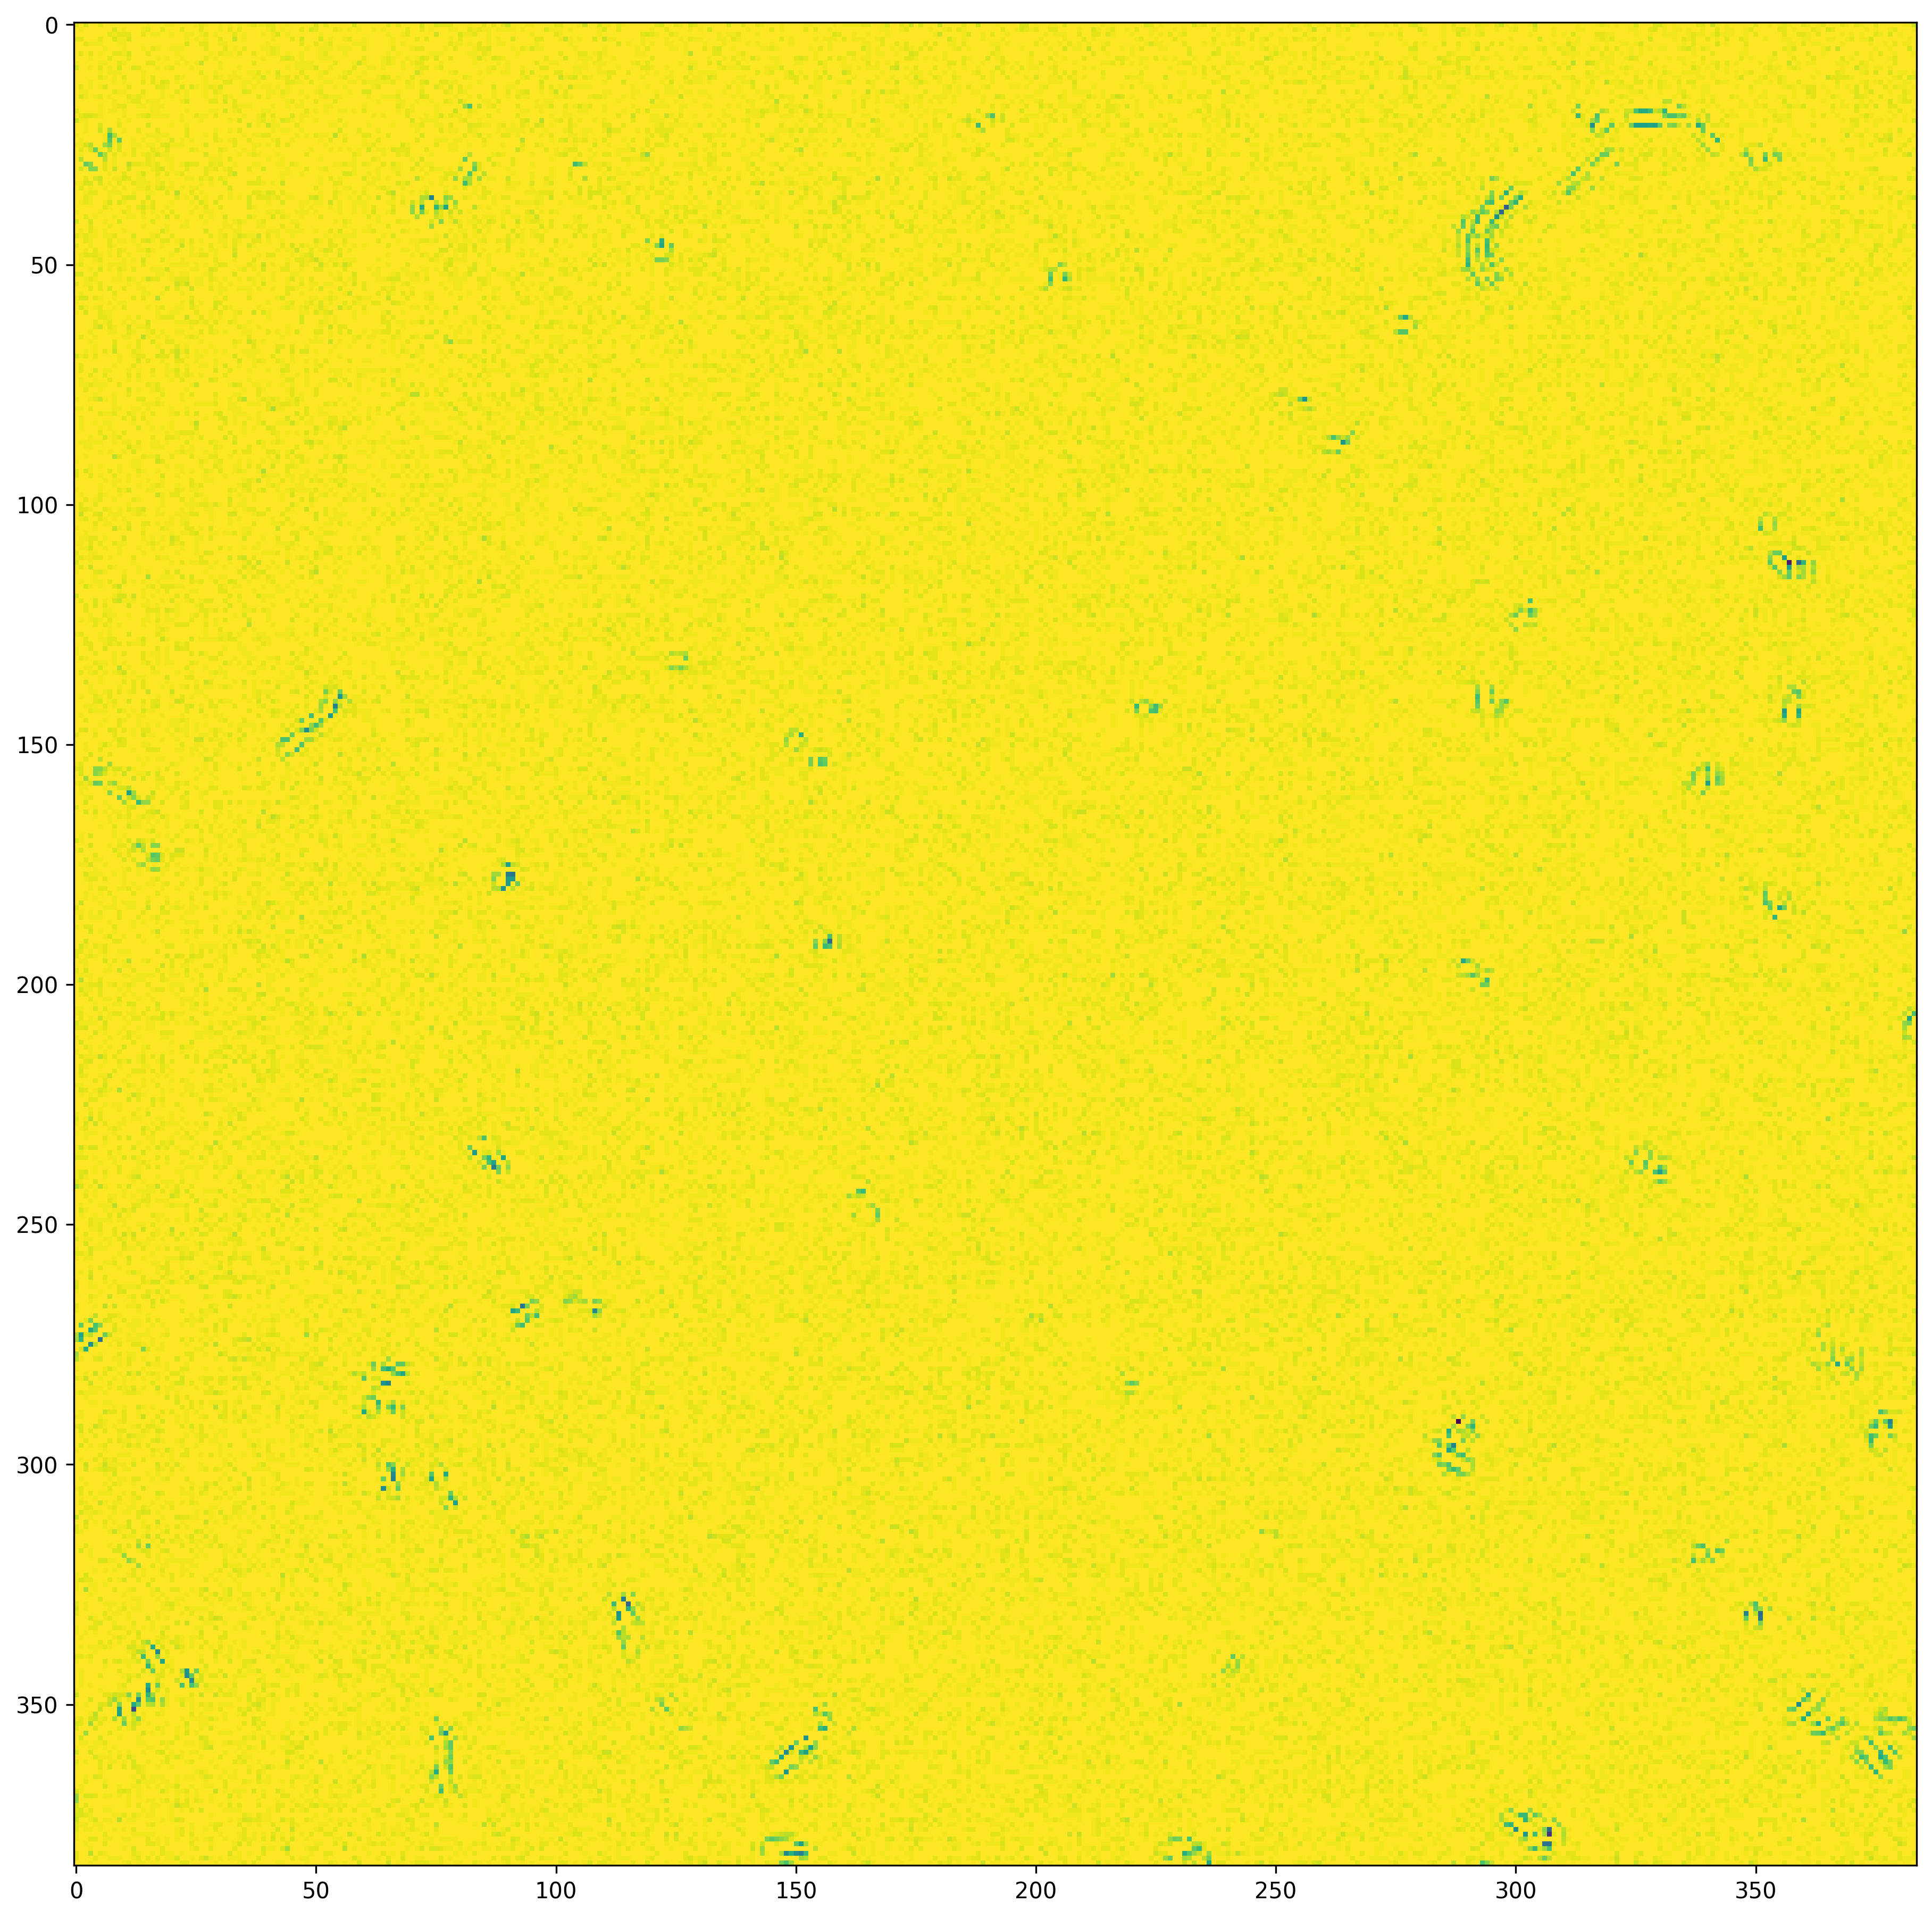

In [17]:
plt.figure(figsize=(15,15),dpi=300)
plt.imshow(images[30])


In [18]:
from torch import nn
import torch.nn.functional as F


class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

        # self.fc1=nn.Linear(4000,2000)
        # self.fc2 = nn.Linear(2000,1000)

        #self.fc3=nn.Linear(1000,1000)
        # self.fc3_2=nn.Linear(10,1)
        # self.fc4=nn.Linear(4000,10)
        # self.fc4_2=nn.Linear(10,1)
        # self.fc5=nn.Linear(4000,10)
        # self.fc5_2=nn.Linear(10,1)

    def forward(self, x):
        x = self.m1(x)
        
        # x = F.gelu(self.fc1(x))
        # x = self.fc2(x)
       # x = self.fc3(x)

        # x2 = F.gelu(self.fc3(x))
        # x2 = self.fc3_2(x2)
        # x3 = F.gelu(self.fc4(x))
        # x3 = self.fc4_2(x3)
        # x4 = F.gelu(self.fc5(x))
        # x4 = self.fc5_2(x4)

        return x#,x2,x3,x4
    

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
device='cuda'
# m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
# model=Net2()
# model.to(device)
# Define your custom dataset

class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()

In [20]:
model2 = Net0()
model2.load_state_dict(torch.load('speed_model_Volo384_dispBrown_fullv2'))
model2.to(device).eval()

Net0(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
   

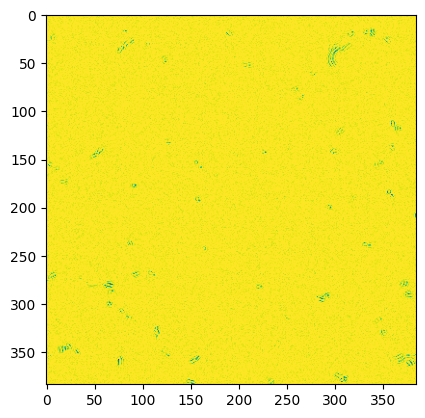

In [21]:
images = torch.tensor(images[1:])
dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 40
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
x = next(iter(test_dataloader))
plt.imshow(x[39])

In [22]:
outputs=[]
model2.eval()
with torch.no_grad():
    for x in test_dataloader:
        out1 = model2(x.unsqueeze(0).to(device)).detach().cpu().numpy()
        outputs.append(out1)

In [24]:
out = np.reshape(np.hstack(outputs),[40000 ,])
out.shape

(40000,)

### Geobacter 1 = "out"

(0.0001, 0.1)

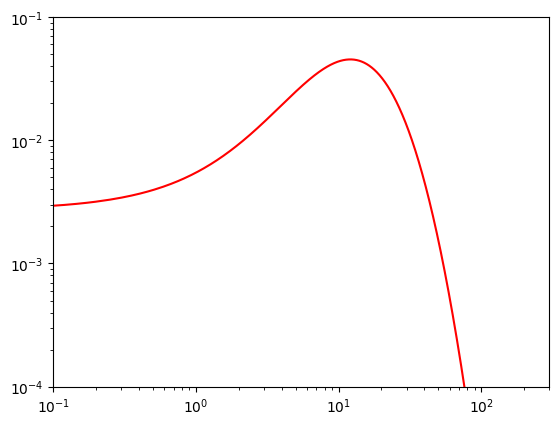

In [33]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c= lognorm.fit(np.sort(out*.325/.1))
xtorch= np.linspace(lognorm.ppf(0.0001, a,b,c),
                lognorm.ppf(0.9999, a,b,c), 4000)
distr_torch=lognorm.pdf(xtorch, a,b,c)
plt.plot(xtorch,distr_torch,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

(0.0001, 0.1)

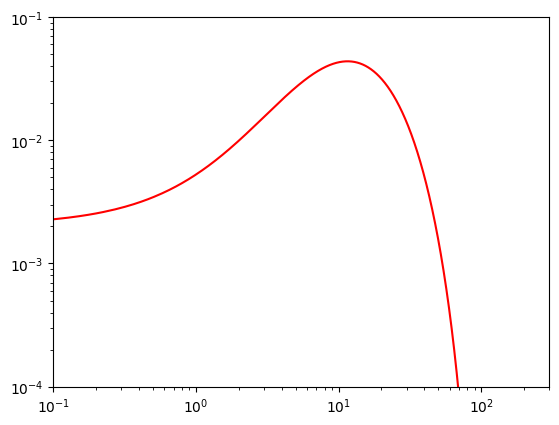

In [32]:
from scipy.stats import exponweib,lognorm,johnsonsb
a,b,c,d = johnsonsb.fit(np.sort(out*.325/.1))
xtorch= np.linspace(johnsonsb.ppf(0.000001, a,b,c,d),
                johnsonsb.ppf(0.999999, a,b,c,d), 4000)
distr_torch=johnsonsb.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

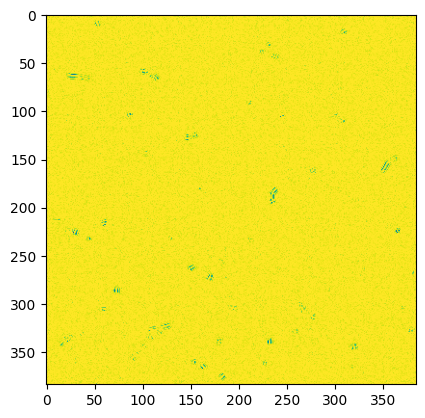

In [34]:
base='C:/Users/marcb/Downloads/OneDrive_1_4-17-2024/FR_1ulh_20X_25fps_1x1y_5min_002_frames/'
files=os.listdir(base)
full_files=[]
sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
for i in range(len(sorted_frames)):
    file = base+sorted_frames[i]
    full_files.append(file)
import cv2
images = np.zeros([len(full_files), 384, 384])
for i in range(len(full_files)):
    images[i]=cv2.resize(cv2.imread(full_files[i], cv2.IMREAD_GRAYSCALE), [384,384])
for i in range(3,len(images)):
    tst=images[i]/255-images[i-2]/255
    tst[tst<0]=0
    tst=(tst-np.min(tst))/(np.max(tst)-np.min(tst))
#im_for = (im_for-np.min(im_for))/(np.max(im_for)-np.min(im_for))
    images[i-2]=1-tst

images = torch.tensor(images[1:])
dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 40
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
x = next(iter(test_dataloader))
plt.imshow(x[0])

In [35]:
outputs=[]
model2.eval()
with torch.no_grad():
    for x in test_dataloader:
        out1 = model2(x.unsqueeze(0).to(device)).detach().cpu().numpy()
        outputs.append(out1)


In [38]:
out2 = np.reshape(np.hstack(outputs),[43000,])
out2.shape

(43000,)

(0.0001, 0.1)

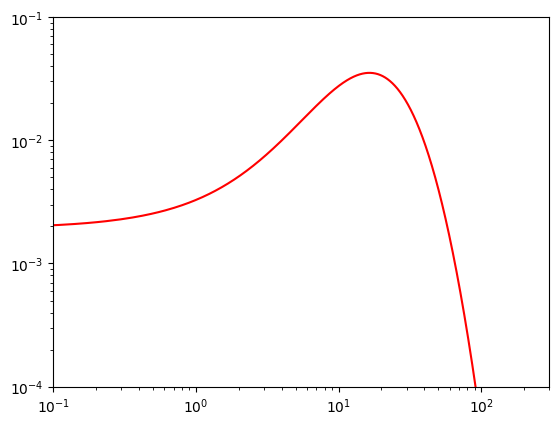

In [39]:
from scipy.stats import exponweib,lognorm, beta, betaprime
a,b,c = lognorm.fit(np.sort(out2*.325/.1))
xtorch2= np.linspace(lognorm.ppf(0.0001, a,b,c),
                lognorm.ppf(0.9999, a,b,c), 4000)
distr_torch2=lognorm.pdf(xtorch2, a,b,c)
plt.plot(xtorch2,distr_torch2,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

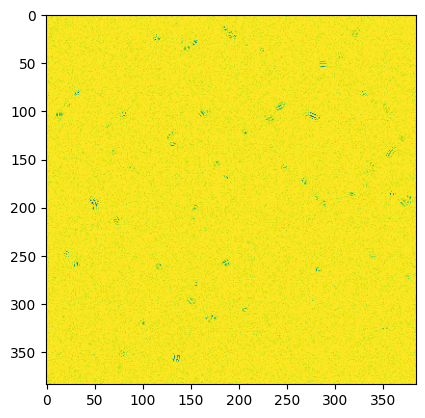

In [40]:
base='C:/Users/marcb/Downloads/OneDrive_1_4-17-2024/FR_1ulh_20X_25fps_1x1y_5min_003_frames/'
files=os.listdir(base)
full_files=[]
sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
for i in range(len(sorted_frames)):
    file = base+sorted_frames[i]
    full_files.append(file)
import cv2
images = np.zeros([len(full_files), 384, 384])
for i in range(len(full_files)):
    images[i]=cv2.resize(cv2.imread(full_files[i], cv2.IMREAD_GRAYSCALE), [384,384])
for i in range(3,len(images)):
    tst=images[i]/255-images[i-2]/255
    tst[tst<0]=0
    tst=(tst-np.min(tst))/(np.max(tst)-np.min(tst))
#im_for = (im_for-np.min(im_for))/(np.max(im_for)-np.min(im_for))
    images[i-2]=1-tst

images = torch.tensor(images[1:])
dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 40
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
x = next(iter(test_dataloader))
plt.imshow(x[0])

In [41]:
outputs=[]
model2.eval()
with torch.no_grad():
    for x in test_dataloader:
        out1 = model2(x.unsqueeze(0).to(device)).detach().cpu().numpy()
        outputs.append(out1)

In [43]:
out3 = np.reshape(np.hstack(outputs),[41500,])
out3.shape

(41500,)

(0.0001, 0.1)

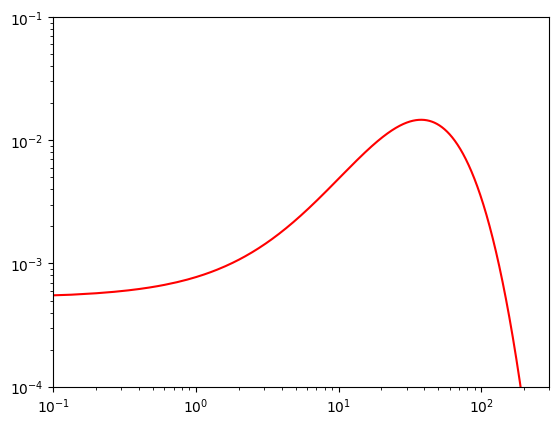

In [144]:
from scipy.stats import exponweib,lognorm,johnsonsu, levy, norm
a,b,c,d = betaprime.fit(np.sort(out3*.325/.1))
xtorch3= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_torch3=betaprime.pdf(xtorch3, a,b,c,d)
plt.plot(xtorch3,distr_torch3,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

In [115]:
out*.325/.1

array([  2.2487407 ,   0.29196835,   1.0118574 , ..., 129.23865   ,
       117.107956  , 122.722206  ], dtype=float32)

(0.0001, 0.1)

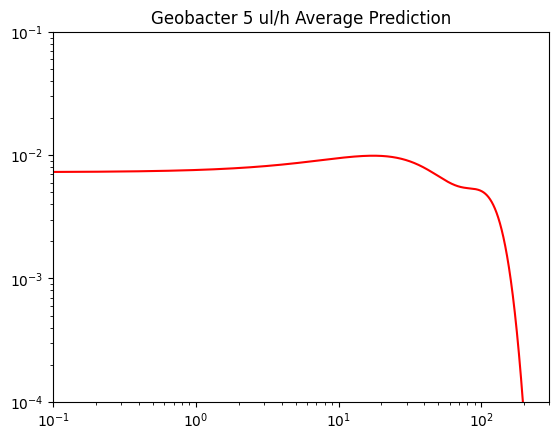

In [163]:
final_xtorch = (xtorch+xtorch2+xtorch3)/3
final_distr_torch = (distr_torch+distr_torch2+distr_torch3)/3
# a,b,c = lognorm.fit(final_out)
# xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
#                 lognorm.ppf(0.99, a,b,c), 4000)
# distr_torch=lognorm.pdf(xtorch, a,b,c)
plt.plot(final_xtorch,final_distr_torch,c='r')
plt.xscale('log')
plt.yscale('log')
plt.title('Geobacter 5 ul/h Average Prediction')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

(0.0001, 0.1)

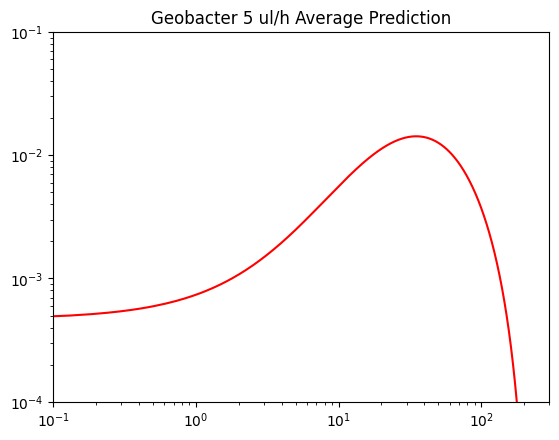

In [125]:
final_xtorch = (xtorch+xtorch2+xtorch3)/3
final_distr_torch = (distr_torch+distr_torch2+distr_torch3)/3
# a,b,c = lognorm.fit(final_out)
# xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
#                 lognorm.ppf(0.99, a,b,c), 4000)
# distr_torch=lognorm.pdf(xtorch, a,b,c)
plt.plot(final_xtorch,final_distr_torch,c='r')
plt.xscale('log')
plt.yscale('log')
plt.title('Geobacter 5 ul/h Average Prediction')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

In [160]:
np.sort(np.reshape(np.array(geo_5ulh),[179364,])).shape

(179364,)

In [173]:

def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector

x_or = np.sort(np.reshape(np.array(geo_5ulh),[179364,]))
x_or = x_or[x_or<600]
x_or = interpolate_vectors(x_or, len(out3))

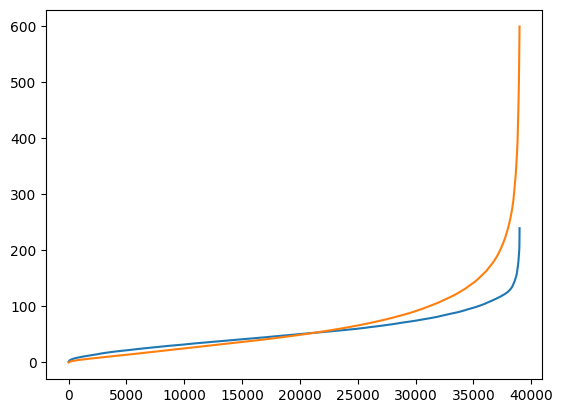

In [174]:
plt.plot(np.sort(out3*.325/.1))
plt.plot(x_or)

(0.0001, 0.1)

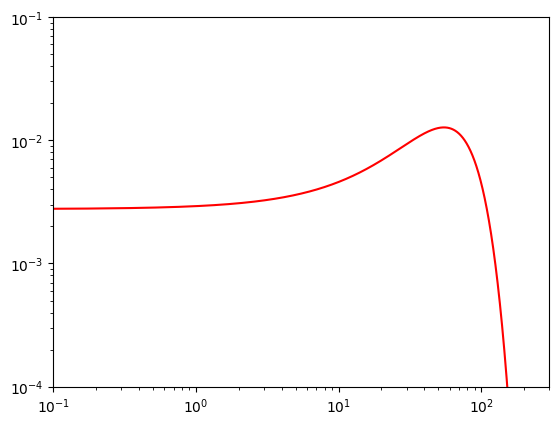

In [153]:
from scipy.stats import exponweib,lognorm,johnsonsu, levy, norm
a,b= norm.fit(np.sort(out3*.325/.1))
xtorch3= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), 4000)
distr_torch3=norm.pdf(xtorch3, a,b)
plt.plot(xtorch3,distr_torch3,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

(0.0001, 0.1)

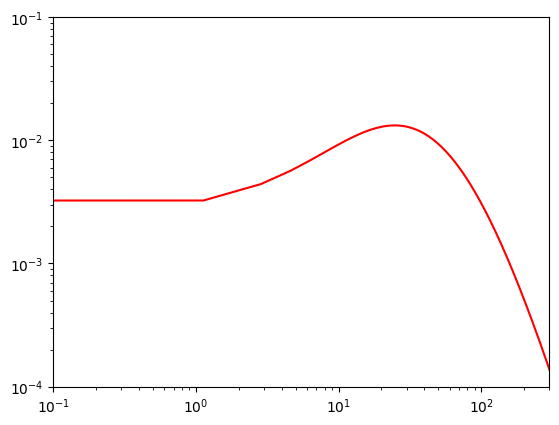

In [172]:
#geo_5ulh = pd.read_csv('geo_8020_5ulh_tmate.csv')
from scipy.stats import exponweib,lognorm,johnsonsu, levy, norm
a,b,c,d = betaprime.fit(x_or)
xtorch3= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 1000)
distr_torch3=betaprime.pdf(xtorch3, a,b,c,d)
plt.plot(xtorch3,distr_torch3,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,3e2])
plt.ylim([1e-4,.1])

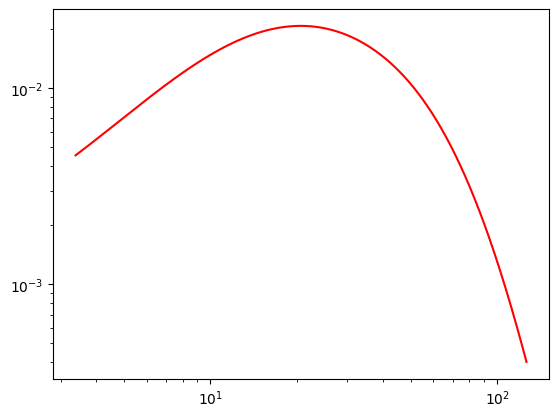

In [61]:
final_xtorch = (xtorch+xtorch2+xtorch3)/3
final_distr_torch = (distr_torch+distr_torch2+distr_torch3)/3
# a,b,c = lognorm.fit(final_out)
# xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
#                 lognorm.ppf(0.99, a,b,c), 4000)
# distr_torch=lognorm.pdf(xtorch, a,b,c)
plt.plot(final_xtorch,final_distr_torch,c='r')
plt.xscale('log')
plt.yscale('log')

# Model Training

In [1]:
import os

sim_dir = os.listdir('all_sims')
file_dir = os.listdir('all_traj_files')
# Custom sorting key function
def sort_key(item):
    if '_brown' in item:
        return (1, int(item[3:-6]))
    else:
        return (0, int(item[3:]))

# Sort the list using the custom key
sorted_sim_dir = sorted(sim_dir, key=sort_key)

print(sorted_sim_dir)

['sim61', 'sim62', 'sim63', 'sim64', 'sim65', 'sim66', 'sim67', 'sim68', 'sim69', 'sim70', 'sim71', 'sim72', 'sim73', 'sim74', 'sim75', 'sim76', 'sim77', 'sim78', 'sim79', 'sim80', 'sim81', 'sim82', 'sim83', 'sim84', 'sim85', 'sim86', 'sim87', 'sim88', 'sim89', 'sim90', 'sim91', 'sim92', 'sim93', 'sim94', 'sim95', 'sim96', 'sim97', 'sim98', 'sim99', 'sim100', 'sim101', 'sim102', 'sim103', 'sim104', 'sim105', 'sim106', 'sim107', 'sim108', 'sim109', 'sim110', 'sim111', 'sim112', 'sim113', 'sim114', 'sim115', 'sim116', 'sim117', 'sim118', 'sim119', 'sim120', 'sim121', 'sim122', 'sim123', 'sim124', 'sim125', 'sim126', 'sim127', 'sim128', 'sim129', 'sim130', 'sim131', 'sim132', 'sim133', 'sim134', 'sim135', 'sim136', 'sim137', 'sim138', 'sim139', 'sim140', 'sim141', 'sim142', 'sim143', 'sim144', 'sim145', 'sim146', 'sim147', 'sim148', 'sim149', 'sim150', 'sim151', 'sim152', 'sim153', 'sim154', 'sim155', 'sim156', 'sim157', 'sim158', 'sim159', 'sim161', 'sim162', 'sim163', 'sim164', 'sim165'

In [2]:
import os


# Custom sorting key function
def sort_key2(item):
    if '_brown' in item:
        return (1, int(item[6:-10]))  # Extract the numeric part for files with '_brown'
    else:
        return (0, int(item[6:-4]))  # Extract the numeric part for files without '_brown'

# Sort the list using the custom key
sorted_file_dir = sorted(file_dir, key=sort_key2)

# Split the sorted list into 'yc_' and 'xc_' files
yc_files = [f for f in sorted_file_dir if f.startswith('yc_')]
xc_files = [f for f in sorted_file_dir if f.startswith('xc_')]

# Create a list of lists with corresponding 'yc_' and 'xc_' files
sorted_file_pairs = [[yc, xc] for yc, xc in zip(yc_files, xc_files)]

print(sorted_file_pairs)

[['yc_sim61.csv', 'xc_sim61.csv'], ['yc_sim62.csv', 'xc_sim62.csv'], ['yc_sim63.csv', 'xc_sim63.csv'], ['yc_sim64.csv', 'xc_sim64.csv'], ['yc_sim65.csv', 'xc_sim65.csv'], ['yc_sim66.csv', 'xc_sim66.csv'], ['yc_sim67.csv', 'xc_sim67.csv'], ['yc_sim68.csv', 'xc_sim68.csv'], ['yc_sim69.csv', 'xc_sim69.csv'], ['yc_sim70.csv', 'xc_sim70.csv'], ['yc_sim71.csv', 'xc_sim71.csv'], ['yc_sim72.csv', 'xc_sim72.csv'], ['yc_sim73.csv', 'xc_sim73.csv'], ['yc_sim74.csv', 'xc_sim74.csv'], ['yc_sim75.csv', 'xc_sim75.csv'], ['yc_sim76.csv', 'xc_sim76.csv'], ['yc_sim77.csv', 'xc_sim77.csv'], ['yc_sim78.csv', 'xc_sim78.csv'], ['yc_sim79.csv', 'xc_sim79.csv'], ['yc_sim80.csv', 'xc_sim80.csv'], ['yc_sim81.csv', 'xc_sim81.csv'], ['yc_sim82.csv', 'xc_sim82.csv'], ['yc_sim83.csv', 'xc_sim83.csv'], ['yc_sim84.csv', 'xc_sim84.csv'], ['yc_sim85.csv', 'xc_sim85.csv'], ['yc_sim86.csv', 'xc_sim86.csv'], ['yc_sim87.csv', 'xc_sim87.csv'], ['yc_sim88.csv', 'xc_sim88.csv'], ['yc_sim89.csv', 'xc_sim89.csv'], ['yc_sim90.cs

In [3]:
test_dirs = sorted_file_pairs[0::4]
len(test_dirs)

73

In [4]:
train_dirs = sorted_file_pairs[1::4]+sorted_file_pairs[2::4]+sorted_file_pairs[3::4]
len(train_dirs)

216

In [5]:
test_image_files = sorted_sim_dir[0::4]
test_image_files

['sim61',
 'sim65',
 'sim69',
 'sim73',
 'sim77',
 'sim81',
 'sim85',
 'sim89',
 'sim93',
 'sim97',
 'sim101',
 'sim105',
 'sim109',
 'sim113',
 'sim117',
 'sim121',
 'sim125',
 'sim129',
 'sim133',
 'sim137',
 'sim141',
 'sim145',
 'sim149',
 'sim153',
 'sim157',
 'sim162',
 'sim166',
 'sim170',
 'sim174',
 'sim178',
 'sim182',
 'sim186',
 'sim190',
 'sim194',
 'sim198',
 'sim202',
 'sim206',
 'sim210',
 'sim214',
 'sim218',
 'sim222',
 'sim226',
 'sim230',
 'sim234',
 'sim238',
 'sim242',
 'sim246',
 'sim250',
 'sim4_brown',
 'sim8_brown',
 'sim12_brown',
 'sim16_brown',
 'sim20_brown',
 'sim24_brown',
 'sim28_brown',
 'sim32_brown',
 'sim36_brown',
 'sim40_brown',
 'sim44_brown',
 'sim48_brown',
 'sim52_brown',
 'sim56_brown',
 'sim60_brown',
 'sim64_brown',
 'sim68_brown',
 'sim72_brown',
 'sim76_brown',
 'sim80_brown',
 'sim84_brown',
 'sim88_brown',
 'sim92_brown',
 'sim96_brown',
 'sim100_brown']

In [6]:
train_image_files = sorted_sim_dir[1::4]+sorted_sim_dir[2::4]+sorted_sim_dir[3::4]
train_image_files

['sim62',
 'sim66',
 'sim70',
 'sim74',
 'sim78',
 'sim82',
 'sim86',
 'sim90',
 'sim94',
 'sim98',
 'sim102',
 'sim106',
 'sim110',
 'sim114',
 'sim118',
 'sim122',
 'sim126',
 'sim130',
 'sim134',
 'sim138',
 'sim142',
 'sim146',
 'sim150',
 'sim154',
 'sim158',
 'sim163',
 'sim167',
 'sim171',
 'sim175',
 'sim179',
 'sim183',
 'sim187',
 'sim191',
 'sim195',
 'sim199',
 'sim203',
 'sim207',
 'sim211',
 'sim215',
 'sim219',
 'sim223',
 'sim227',
 'sim231',
 'sim235',
 'sim239',
 'sim243',
 'sim247',
 'sim1_brown',
 'sim5_brown',
 'sim9_brown',
 'sim13_brown',
 'sim17_brown',
 'sim21_brown',
 'sim25_brown',
 'sim29_brown',
 'sim33_brown',
 'sim37_brown',
 'sim41_brown',
 'sim45_brown',
 'sim49_brown',
 'sim53_brown',
 'sim57_brown',
 'sim61_brown',
 'sim65_brown',
 'sim69_brown',
 'sim73_brown',
 'sim77_brown',
 'sim81_brown',
 'sim85_brown',
 'sim89_brown',
 'sim93_brown',
 'sim97_brown',
 'sim63',
 'sim67',
 'sim71',
 'sim75',
 'sim79',
 'sim83',
 'sim87',
 'sim91',
 'sim95',
 'sim9

In [7]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import re
#torch.set_default_dtype(torch.float16)
k=40


# train_image_files=['../500part_4xspeed_heterogeneous/','../2000part_4xspeed_heterogeneous/', '../2000part_16xspeed_heterogeneous/',
#                   '../2000part_32xspeed_heterogeneous/','../1000part_16xspeed_heterogeneous/','../500part_32xspeed_heterogeneous/',
#                   '../1000part_32xspeed_heterogeneous/', 'sim2/', 'sim11/', 'sim12/', 'sim13/', 'sim14/', 'sim19/','sim20/','sim21/',
#                    'sim22/','sim23/','sim24/','sim25/','sim35/','sim36/','sim46/','sim62/','sim63/','sim64/','sim65/','sim66/',
#                   'sim67/','sim16/']
# train_image_files=['sim62/','sim63/','sim64/','sim66/',
#                   'sim67/','sim68/','sim69/', 'sim72/','sim73/','sim74/','sim76/',
#                   'sim77/','sim78/','sim79/', 'sim82/','sim83/','sim84/','sim86/',
#                   'sim87/','sim88/','sim89/', 'sim92/','sim93/','sim94/','sim96/',
#                   'sim97/','sim98/','sim99/', 'sim102/','sim103/','sim104/','sim106/',
#                   'sim107/','sim108/','sim109/', 'sim112/','sim113/','sim114/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim122/','sim123/','sim124/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim132/','sim133/','sim134/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim142/','sim143/','sim144/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim112/','sim113/','sim114/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim112/','sim113/','sim114/','sim116/',
#                   'sim117/','sim118/','sim119/']
# test_image_files=['sim61/','sim65/','sim70/','sim71/','sim75/','sim80/','sim81/','sim85/','sim90/',
#                   'sim91/','sim95/','sim100/','sim101/','sim105/','sim110/','sim111/','sim115/','sim120/']
s=384
images_train = torch.zeros(len(train_image_files),k,s, s)
images_test = torch.zeros(len(test_image_files),k,s, s)
for i in range(len(train_image_files)):
    base = 'all_sims/'+train_image_files[i]
    im_dir = os.listdir(base)
    im_dir = sorted(im_dir, key=lambda x: int(re.findall(r'\d+', x)[0]))
    for j in range(k):
        images_train[i,j,:,:] = torch.tensor(cv2.resize(cv2.imread(base+'/'+im_dir[j], cv2.IMREAD_GRAYSCALE),(s,s)))


for i in range(len(test_image_files)):
    base = 'all_sims/'+test_image_files[i]
    im_dir = os.listdir(base)
    im_dir = sorted(im_dir, key=lambda x: int(re.findall(r'\d+', x)[0]))
    for j in range(k):
        images_test[i,j,:,:] = torch.tensor(cv2.resize(cv2.imread(base+'/'+im_dir[j], cv2.IMREAD_GRAYSCALE),(s,s)))
        
im_dir

['Fig_1.jpg',
 'Fig_2.jpg',
 'Fig_3.jpg',
 'Fig_4.jpg',
 'Fig_5.jpg',
 'Fig_6.jpg',
 'Fig_7.jpg',
 'Fig_8.jpg',
 'Fig_9.jpg',
 'Fig_10.jpg',
 'Fig_11.jpg',
 'Fig_12.jpg',
 'Fig_13.jpg',
 'Fig_14.jpg',
 'Fig_15.jpg',
 'Fig_16.jpg',
 'Fig_17.jpg',
 'Fig_18.jpg',
 'Fig_19.jpg',
 'Fig_20.jpg',
 'Fig_21.jpg',
 'Fig_22.jpg',
 'Fig_23.jpg',
 'Fig_24.jpg',
 'Fig_25.jpg',
 'Fig_26.jpg',
 'Fig_27.jpg',
 'Fig_28.jpg',
 'Fig_29.jpg',
 'Fig_30.jpg',
 'Fig_31.jpg',
 'Fig_32.jpg',
 'Fig_33.jpg',
 'Fig_34.jpg',
 'Fig_35.jpg',
 'Fig_36.jpg',
 'Fig_37.jpg',
 'Fig_38.jpg',
 'Fig_39.jpg',
 'Fig_40.jpg']

torch.Size([216, 40, 384, 384])

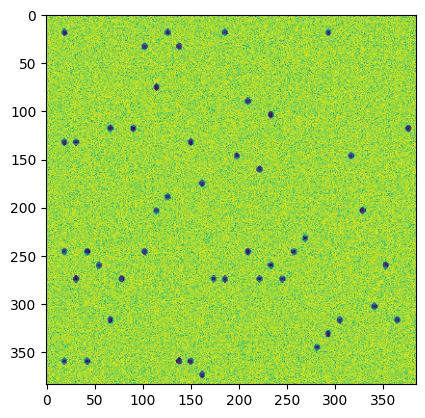

In [8]:
import matplotlib.pyplot as plt
plt.imshow(images_train[96,0,:,:])
images_train.shape

In [9]:
import gc
del im_dir
gc.collect()

3298

In [10]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import re
import matplotlib.pyplot as plt
from scipy.stats import exponweib,lognorm

def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector
    

base='all_traj_files/'
target_length=500
speeds = torch.zeros(len(train_dirs),target_length)
for i in range(len(train_dirs)):
    x_arr= np.array(pd.read_csv(base+train_dirs[i][1], header=None))
    y_arr= np.array(pd.read_csv(base+train_dirs[i][0], header=None))
    vx = np.diff(x_arr, axis=0)
    vy = np.diff(y_arr, axis=0)
    speed = np.sqrt(vx**2+vy**2)
    speed = np.reshape(speed, [-1])
    speed=speed[~np.isnan(speed)]
    speed = interpolate_vectors(np.sort(speed), target_length)
    speeds[i,:] = torch.tensor(speed)


In [11]:
# xtorch_test = torch.zeros(len(test_dirs),1000)
# distr_torch_test = torch.zeros(len(test_dirs),1000)

# test_dirs=[["xc_1000part_4xspeed.csv","yc_1000part_4xspeed.csv"],["xc_500part_16xspeed.csv","yc_500part_16xspeed.csv"],
#           ['yc_sim17.csv','xc_sim17.csv'],['yc_sim18.csv','xc_sim18.csv'], ['yc_sim40.csv','xc_sim40.csv'], ['yc_sim41.csv','xc_sim41.csv'], 
#            ['yc_sim42.csv','xc_sim42.csv'], ['yc_sim43.csv','xc_sim43.csv'], ['yc_sim44.csv','xc_sim44.csv'], ['yc_sim45.csv','xc_sim45.csv'],
#            ['yc_sim69.csv','xc_sim69.csv'],['yc_sim70.csv','xc_sim70.csv'],
# ]
# test_dirs=[ ['yc_sim61.csv','xc_sim61.csv'], ['yc_sim65.csv','xc_sim65.csv'],['yc_sim70.csv','xc_sim70.csv'],
#            ['yc_sim71.csv','xc_sim71.csv'], ['yc_sim75.csv','xc_sim75.csv'],['yc_sim80.csv','xc_sim80.csv'],
#            ['yc_sim81.csv','xc_sim81.csv'], ['yc_sim85.csv','xc_sim85.csv'],['yc_sim90.csv','xc_sim90.csv'],
# ]
# scales_test = torch.zeros(len(test_dirs),3)
# target_length=1000
speeds_test = torch.zeros(len(test_dirs),target_length)
for i in range(len(test_dirs)):
    x_arr= np.array(pd.read_csv(base+test_dirs[i][1], header=None))
    y_arr= np.array(pd.read_csv(base+test_dirs[i][0], header=None))
    vx = np.diff(x_arr, axis=0)
    vy = np.diff(y_arr, axis=0)
    speed = np.sqrt(vx**2+vy**2)
    speed = np.reshape(speed, [-1])
    speed=speed[~np.isnan(speed)]
    speed = interpolate_vectors(np.sort(speed), target_length)
    speeds_test[i,:] = torch.tensor(speed)


In [12]:
import timm
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [10]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        l=200
        self.fc2=nn.Conv2d(100, l, 1, stride=2)
        #self.m1 = nn.BatchNorm1d(1000)
        self.d1 = nn.Dropout(.2)
        self.fc1=nn.Conv2d(40, 100, 1, stride=2)
        #self.m2 = nn.BatchNorm1d(l)
        self.d2 = nn.Dropout(.2)
       # self.fc2 = nn.Linear(800,l)
       # self.fc3=nn.Linear(2000,800)
       # self.fc4 = nn.Linear(800,l)
        self.fc5 = nn.Conv2d(l, 5,1, stride=1)
        #self.m3 = nn.BatchNorm1d(100)
        self.fc6 = nn.Linear(312500,1000)
        self.d3 = nn.Dropout(.2)
        self.fc7 = nn.Linear(100,4)
        self.fc8 = nn.Linear(2000,1000)

    def forward(self, x):
        b = x.shape[0]
        x = x.squeeze()
        
        l=200
        x = F.relu(self.fc1(x))
        #x = self.m1(x)
        x = self.d1(x)
        x = F.relu(self.fc2(x))
        #x = self.m2(x)
        x = self.d2(x)
        #x = x.permute(0,2,1)
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        
        #x = x.view(b,l*666)
        x = F.relu(self.fc5(x))
        #x = self.m3(x)
        x = x.reshape(b, -1)
        #x = F.relu(self.fc4(x))
        x = (self.fc6(x))
        # x = self.d3(x)
        # #x = torch.flatten(x)
        # x = (self.fc8(x))
        # x = x.reshape(2,200)
        #x = self.fc7(x)
        #output = nn.functional.log_softmax(x, dim=1)
        return x
    
    
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

        # self.fc1=nn.Linear(4000,2000)
        # self.fc2 = nn.Linear(2000,1000)

        #self.fc3=nn.Linear(1000,1000)
        # self.fc3_2=nn.Linear(10,1)
        # self.fc4=nn.Linear(4000,10)
        # self.fc4_2=nn.Linear(10,1)
        # self.fc5=nn.Linear(4000,10)
        # self.fc5_2=nn.Linear(10,1)

    def forward(self, x):
        x = self.m1(x)
        
        # x = F.gelu(self.fc1(x))
        # x = self.fc2(x)
       # x = self.fc3(x)

        # x2 = F.gelu(self.fc3(x))
        # x2 = self.fc3_2(x2)
        # x3 = F.gelu(self.fc4(x))
        # x3 = self.fc4_2(x3)
        # x4 = F.gelu(self.fc5(x))
        # x4 = self.fc5_2(x4)

        return x#,x2,x3,x4
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        l=80

        self.fc1=nn.Linear(1000,l)
        self.d1 = nn.Dropout(.1)
        self.fc2=nn.Linear(1000,l)
        self.d2 = nn.Dropout(.1)
        self.fc3 = nn.Linear(40*l*l,1000)
        self.d3 = nn.Dropout(.1)
        self.fc4 = nn.Linear(1000,250)
        self.fc4_2 = nn.Linear(250,1000)
#         self.fc4_3 = nn.Linear(800,300)
#         self.fc5 = nn.Linear(300,30)
# #         self.fc5_2 = nn.Linear(200,100)
# #         self.fc5_3 = nn.Linear(100,30)
#         self.fc6 = nn.Linear(30,3)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.fc1(x))
        x = self.d1(x)
        x = x.permute(0,1,3,2)
        x = F.relu(self.fc2(x))
        x = self.d2(x)
        x = torch.reshape(x, [b,-1])
        x = F.relu(self.fc3(x))
        x = self.d3(x)
        x = F.relu(self.fc4(x))
        #x = torch.reshape(x, [b,10000])
        x = (self.fc4_2(x))
#         x = F.rrelu(self.fc4_3(x))
#         x = F.rrelu(self.fc5(x))
# #         x = F.rrelu(self.fc5_2(x))
# #         x = F.rrelu(self.fc5_3(x))
#         x = self.fc6(x)
        #x = torch.reshape(x, [b,2,100])
        #x = self.fc7(x)
        #output = nn.functional.log_softmax(x, dim=1)
        return x

In [14]:
images_train = images_train/255
images_test = images_test/255

In [15]:
# from ultralytics import YOLO

# # Load the pretrained YOLO model
# model = YOLO('yolov8n.pt')  # You can choose a different model variant if desired

# import torch
# import torch.nn as nn
# model.model.model[0].conv = nn.Conv2d(40, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# model.model.model[-1].dfl = nn.Conv2d(16, 1000, kernel_size=(1, 1), stride=(1, 1), bias=False)
# model

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

16

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
device='cuda'
# m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
# model=Net2()
# model.to(device)
# Define your custom dataset

class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()


class TestDataset(Dataset):
    def __init__(self, images, x):#x,y,scales):
        self.images = images
        self.x = x
        # self.y = y
        # self.scales = scales

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index,:,:,:]
        #image  = tv.transforms.Resize(size=448)(image)
        #image  = torch.tensor(image)
        x = self.x[index,:]
        # y = torch.tensor(self.y[index,:])
        # scales1 = self.scales[index,0]
        # scales2 = self.scales[index,1]
        # scales3 = self.scales[index,2]
        return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()
import random
class TrainDataset(Dataset):
    def __init__(self, images, x):#x,y,scales):
        self.images = images
        self.x = x
        # self.y = y
        # self.scales = scales

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index,:,:,:]
        #image  = tv.transforms.Resize(size=448)(image)
        # if random.random() < 0.5:
        #     scale_factor = random.uniform(.95, 1.05)
        #     image *= scale_factor
        if random.random() < 0.5:
            image = image.flip(dims=[-1]) 
        if random.random() < 0.5:
            image = image.flip(dims=[-2])  # Assuming W=50 is the middle axis for flipping

    # # Flip across the horizontal axis (H dimension) for input and label with a 50% chance
        if random.random() < 0.5:
            # # For input, assuming H=200 is the middle
            image = image.flip(dims=[-3])  # Flipping the last dimension (H)
            # # For label, assuming H=1000 is the middle
        

        x = self.x[index,:]
        # y = torch.tensor(self.y[index,:])
        # scales1 = self.scales[index,0]
        # scales2 = self.scales[index,1]
        # scales3 = self.scales[index,2]
        return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()


# Define your model architecture

import torch
from torch.utils.data import DataLoader, Sampler
import numpy as np



# Assuming you have your grayscale images and labels loaded in memory
from torch.optim.lr_scheduler import ExponentialLR
# Create an instance of the custom dataset
# x = torch.nan_to_num(xc_data).unsqueeze(dim=2)
# y = torch.nan_to_num(yc_data).unsqueeze(dim=2)
# x_test = torch.nan_to_num(xc_data3).unsqueeze(dim=2)
# y_test = torch.nan_to_num(yc_data3).unsqueeze(dim=2)
# coords = torch.cat((x,y), dim=2)
# coords_test = torch.cat((x_test,y_test), dim=2)
#images = images[0:14,:,:]
# from sklearn.preprocessing import StandardScaler
# scalerx = StandardScaler()
# scalery = StandardScaler()
# # xtorch=scalerx.fit_transform(xtorch)
# # distr_torch=scalery.fit_transform(distr_torch)
# maxs = torch.max(scales)
# # mins = torch.min(scales)
# # print(maxs,mins)
# scales2 = (scales)/(maxs)
# # scales2 = (scales-mins)/(maxs-mins)

# maxs = torch.max(speeds)
# mins = torch.min(speeds)
# print(maxs)#,mins)
# # scales_test2 = (scales_test)/(maxs)
# speeds2 = (speeds/maxs)#-mins)/(maxs-mins)

# # maxs = torch.max(speeds_test)
# # mins = torch.min(speeds_test)
# # print(maxs,mins)
# # scales_test2 = (scales_test)/(maxs)
# speeds_test2 = (speeds_test/maxs)#-mins)/(maxs-mins)
# xtorch_test=scalerx.transform(xtorch_test)
# distr_torch_test=scalery.transform(distr_torch_test)
dataset = TrainDataset(images_train, speeds)#xtorch, distr_torch,scales2)


# Create a dataloader
batch_size = 32
torch.cuda.empty_cache()
gc.collect()
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# Create the GroupedSampler with a group size of 4
#sampler = GroupedSampler(dataset, group_size=batch_size)
#images3 = images3.unsqueeze(dim=0)
# Create the DataLoader with the GroupedSampler
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,drop_last=False,num_workers=0)#,sampler=sampler)
dataset_test = TestDataset(images_test,speeds_test)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 10
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

NameError: name 'images_train' is not defined

In [14]:
dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 10
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

In [19]:
images.shape

(2582, 384, 384)

In [24]:
# device='cuda'
# model2 = Net0()
# model2.load_state_dict(torch.load('speed_model_Volo384_dispBrown_fullv2'))
# model2.to(device).eval()
model2(torch.tensor(images[0:40]).to(device).float())

ValueError: expected 4D input (got 3D input)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
device='cuda'
# m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
model=Net0()
model.to(device)
# Define your custom dataset
class TestDataset(Dataset):
    def __init__(self, images, x):#x,y,scales):
        self.images = images
        self.x = x
        # self.y = y
        # self.scales = scales

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index,:,:,:]
        #image  = tv.transforms.Resize(size=448)(image)
        #image  = torch.tensor(image)
        x = self.x[index,:]
        # y = torch.tensor(self.y[index,:])
        # scales1 = self.scales[index,0]
        # scales2 = self.scales[index,1]
        # scales3 = self.scales[index,2]
        return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()
import random
class TrainDataset(Dataset):
    def __init__(self, images, x):#x,y,scales):
        self.images = images
        self.x = x
        # self.y = y
        # self.scales = scales

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index,:,:,:]
        #image  = tv.transforms.Resize(size=448)(image)
        # if random.random() < 0.5:
        #     scale_factor = random.uniform(.95, 1.05)
        #     image *= scale_factor
        if random.random() < 0.5:
            image = image.flip(dims=[-1]) 
        if random.random() < 0.5:
            image = image.flip(dims=[-2])  # Assuming W=50 is the middle axis for flipping

    # # Flip across the horizontal axis (H dimension) for input and label with a 50% chance
        if random.random() < 0.5:
            # # For input, assuming H=200 is the middle
            image = image.flip(dims=[-3])  # Flipping the last dimension (H)
            # # For label, assuming H=1000 is the middle
        

        x = self.x[index,:]
        # y = torch.tensor(self.y[index,:])
        # scales1 = self.scales[index,0]
        # scales2 = self.scales[index,1]
        # scales3 = self.scales[index,2]
        return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()


# Define your model architecture

import torch
from torch.utils.data import DataLoader, Sampler
import numpy as np



# Assuming you have your grayscale images and labels loaded in memory
from torch.optim.lr_scheduler import ExponentialLR
# Create an instance of the custom dataset
# x = torch.nan_to_num(xc_data).unsqueeze(dim=2)
# y = torch.nan_to_num(yc_data).unsqueeze(dim=2)
# x_test = torch.nan_to_num(xc_data3).unsqueeze(dim=2)
# y_test = torch.nan_to_num(yc_data3).unsqueeze(dim=2)
# coords = torch.cat((x,y), dim=2)
# coords_test = torch.cat((x_test,y_test), dim=2)
#images = images[0:14,:,:]
# from sklearn.preprocessing import StandardScaler
# scalerx = StandardScaler()
# scalery = StandardScaler()
# # xtorch=scalerx.fit_transform(xtorch)
# # distr_torch=scalery.fit_transform(distr_torch)
# maxs = torch.max(scales)
# # mins = torch.min(scales)
# # print(maxs,mins)
# scales2 = (scales)/(maxs)
# # scales2 = (scales-mins)/(maxs-mins)

# maxs = torch.max(speeds)
# mins = torch.min(speeds)
# print(maxs)#,mins)
# # scales_test2 = (scales_test)/(maxs)
# speeds2 = (speeds/maxs)#-mins)/(maxs-mins)

# # maxs = torch.max(speeds_test)
# # mins = torch.min(speeds_test)
# # print(maxs,mins)
# # scales_test2 = (scales_test)/(maxs)
# speeds_test2 = (speeds_test/maxs)#-mins)/(maxs-mins)
# xtorch_test=scalerx.transform(xtorch_test)
# distr_torch_test=scalery.transform(distr_torch_test)
dataset = TrainDataset(images_train, speeds)#xtorch, distr_torch,scales2)


# Create a dataloader
batch_size = 16
torch.cuda.empty_cache()
gc.collect()
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# Create the GroupedSampler with a group size of 4
#sampler = GroupedSampler(dataset, group_size=batch_size)
#images3 = images3.unsqueeze(dim=0)
# Create the DataLoader with the GroupedSampler
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,drop_last=False,num_workers=0)#,sampler=sampler)
dataset_test = TestDataset(images_test,speeds_test)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 10
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
# model = Net().to(device)
# model2 = Net2().to(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.0001,weight_decay=.01)
#optimizer2 = optim.Adam(model2.parameters(), lr=0.00001)
gamma = .998# The exponential decay factor (adjust as needed)
#scheduler1 = CosineAnnealingWarmRestarts(optimizer1, 200, 2)
scheduler = ExponentialLR(optimizer, gamma=gamma)
torch.cuda.empty_cache()
gc.collect()

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for im,speed in dataloader:
        # Forward pass
        optimizer.zero_grad()
        outputs = model(im.to(device))
        #outputs2 = model2(outputs.to(device))
        # loss_xt = criterion(outputs[:,0,:].squeeze(), xt.squeeze().to(device))
        # loss_lab = criterion(outputs[:,1,:].squeeze(), lab.squeeze().to(device))
        # loss = criterion(outputs.squeeze(), scale.squeeze().to(device))
        #loss_end = criterion(outputs[:,-20:], speed[:,-20:].to(device))
        loss_mse = criterion(outputs, speed.to(device))
        # ls1 = criterion(out1.squeeze(1), scale1.to(device))
        # ls2 = criterion(out2.squeeze(1), scale2.to(device))
        # ls3 = criterion(out3.squeeze(1), scale3.to(device))
        #loss = loss_lab+loss_xt
        # Backward pass and optimization
        
        #optimizer2.zero_grad()
        loss = loss_mse#+(ls1+ls2+ls3)*3
        loss.backward()
        optimizer.step()
        #optimizer2.step()
        scheduler.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    model.eval()
    running_loss2=0
    running_loss3=0
    with torch.no_grad():
        for im_tst,speed_tst in test_dataloader:
        # Forward pass
            outputs_tst = model(im_tst.to(device))
            # loss_xt = criterion(outputs_tst[:,0,:].squeeze(), xt_tst.squeeze().to(device))
            # loss_lab = criterion(outputs_tst[:,1,:].squeeze(), lab_tst.squeeze().to(device))
            # loss2 = criterion(outputs_tst.squeeze(), scale_tst.squeeze().to(device))
            # ls1 = criterion(a_tst.squeeze(1), s1.to(device))
            # ls2 = criterion(b_tst.squeeze(1), s2.to(device))
            # ls3 = criterion(c_tst.squeeze(1), s3.to(device))
            loss2 = criterion(outputs_tst, speed_tst.to(device))
            #loss3 = (ls1+ls2+ls3)
            #loss2 = loss_lab+loss_xt

#             loss2 = criterion(outputs_tst.squeeze(), scale_tst.squeeze().to(device))

            running_loss2 += loss2.item()
            #running_loss3 += loss3.item()
    epoch_loss2 = running_loss2 / len(test_dataloader)
    #epoch_loss3 = running_loss3 / len(test_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f},  Test Loss: {epoch_loss2:.5f},Learning Rate: {optimizer.param_groups[0]['lr']:.7f}")
    #, Test Loss Distribution Params: {epoch_loss3:.5f}
    torch.cuda.empty_cache()
    gc.collect()
print("Training finished!")

Epoch [1/200], Loss: 93.68324,  Test Loss: 82.33005,Learning Rate: 0.0000972
Epoch [2/200], Loss: 87.42364,  Test Loss: 76.75265,Learning Rate: 0.0000945
Epoch [3/200], Loss: 83.81063,  Test Loss: 71.29040,Learning Rate: 0.0000919


KeyboardInterrupt: 

In [51]:
model

Net2(
  (m1): Beit(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(40, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [21]:
scales

NameError: name 'scales' is not defined

In [26]:
criterion(outputs_tst, speed_tst.to(device))

tensor(19.8604, device='cuda:0')

In [35]:
outputs_tst

torch.Size([40, 384, 384])

In [98]:
model1 = Net0()
model1.load_state_dict(torch.load('speed_model_Volo448_dispBrown_full'))
model1.to(device).eval()

model2 = Net2()
model2.load_state_dict(torch.load('speed_model_Volo384_dispBrown_fullv2'))
model2.to(device).eval()

model3 = Net2()
model3.load_state_dict(torch.load('speed_model_Volo384_dispBrown_fullv3'))
model3.to(device).eval()

Net2(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
   

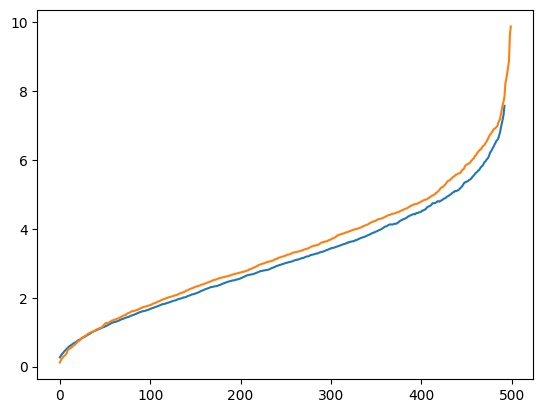

In [99]:
#k=8
ground_truth=[]
preds=[]
losses=[]
with torch.no_grad():
    for im_tst,speed_tst in test_dataloader:
    # Forward pass
        outputs_tst = model3(im_tst.to(device))
        #loss2 = criterion(outputs_tst, speed_tst.to(device))
        out_vecs=[]
        for k in range(len(outputs_tst)):
            out = outputs_tst[k,:].cpu().detach().squeeze()
            #
            
            def rolling_mean(matrix, window):
                df = pd.DataFrame(matrix)
                return df.rolling(window=window).mean().dropna().to_numpy()
            out_mean = rolling_mean(out,8)
            out_mean[out_mean<0]=0.001
            out_vecs.append(out_mean)
       # losses.append(loss2.item())
        preds.append(out_vecs)
        ground_truth.append(speed_tst.numpy())
    # for i in out:
#     if (i>.03)&(count<400):
#         out[:,count
#     count+=1
plt.plot(out_mean)
plt.plot(speed_tst[k])

In [36]:
preds_mean = (preds1+preds2+preds3)
len(preds1[7])

3

In [47]:
len(pred)
len(ground_truth[i][j,4:-3])
torch.tensor(pred)

tensor([[ 0.4889],
        [ 0.5791],
        [ 0.6313],
        [ 0.6901],
        [ 0.7087],
        [ 0.7507],
        [ 0.7830],
        [ 0.8254],
        [ 0.8468],
        [ 0.8793],
        [ 0.9112],
        [ 0.9417],
        [ 0.9931],
        [ 1.0278],
        [ 1.0666],
        [ 1.0896],
        [ 1.1445],
        [ 1.1564],
        [ 1.1980],
        [ 1.2328],
        [ 1.2684],
        [ 1.3078],
        [ 1.3555],
        [ 1.3913],
        [ 1.4316],
        [ 1.4739],
        [ 1.5186],
        [ 1.5435],
        [ 1.5764],
        [ 1.6157],
        [ 1.6344],
        [ 1.6810],
        [ 1.6955],
        [ 1.7274],
        [ 1.7550],
        [ 1.8069],
        [ 1.8490],
        [ 1.8701],
        [ 1.9100],
        [ 1.9301],
        [ 1.9679],
        [ 1.9982],
        [ 2.0201],
        [ 2.0420],
        [ 2.0672],
        [ 2.1089],
        [ 2.1414],
        [ 2.1761],
        [ 2.2091],
        [ 2.2499],
        [ 2.2869],
        [ 2.3105],
        [ 2.

In [103]:
len(preds)
losses=[]
full_preds=[]
criterion = nn.MSELoss()
#ground_truth[-1].shape
for i in range(len(preds)):
    for j in range(len(preds[i])):
        pred = (.00*preds1[i][j]+0.3*preds2[i][j]+.7*preds3[i][j])
        a,b,c = lognorm.fit(pred)

        xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
                        lognorm.ppf(0.99, a,b,c), target_length)
        distr_torch=lognorm.pdf(xtorch, a,b,c)
        #plt.plot(xtorch,distr_torch,c='r')
        
        a,b,c = lognorm.fit(ground_truth[i][j,:])
        xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
                        lognorm.ppf(0.99, a,b,c), target_length)
        distr_torch=lognorm.pdf(xtorch, a,b,c)
        #plt.plot(xtorch,distr_torch,c='g')
        #plt.xlim([0,30])
        #plt.ylim([0,.6])
        full_preds.append(pred)
        loss = criterion(torch.tensor(pred), torch.tensor(ground_truth[i][j,4:-3]))
        losses.append(loss.item())
        #plt.title('Loss = '+str(loss.item()))
        #plt.show()
        
np.mean(losses)
#ground_truth[0].shape

65.74282723583372

Text(0.5, 1.0, 'Loss = 408.0095651208028')

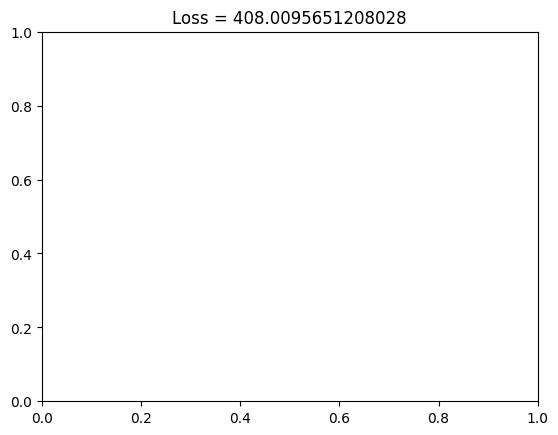

In [58]:
plt.title('Loss = '+str(loss.item()))

In [90]:
flat_pred = np.vstack(full_preds)
flat_pred=np.reshape(flat_pred,[-1,])
flat_pred.shape

(35989,)

73

In [88]:
flat_gt = np.vstack(ground_truth)
flat_gt=np.reshape(flat_gt,[-1,])
flat_gt.shape

(36500,)

In [33]:
torch.save(model.state_dict(), 'speed_model_Volo384_dispBrown_fullv3')

4.2806302062567765
1.0567513017261538 -0.19349838939233482 3.4173772939229576
4.36067847162321
1.1239389 -0.1709736213104448 3.4077132


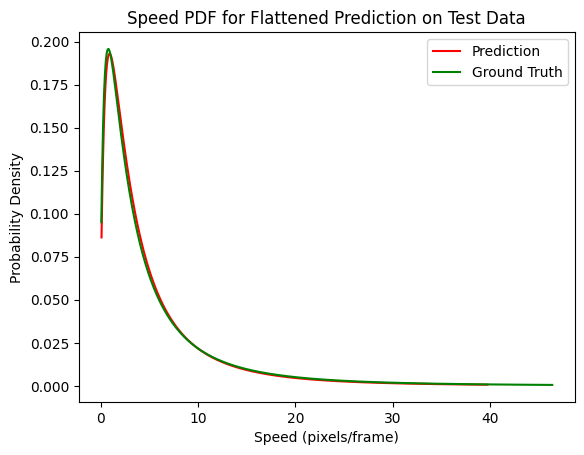

In [91]:
a,b,c = lognorm.fit(flat_pred)
#c=c+.4
#a=a+.1
# Generate points for plotting the fitted distribution
xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
                lognorm.ppf(0.99, a,b,c), target_length)

distr_torch=lognorm.pdf(xtorch, a,b,c)
print(a+b+c)
print(a,b,c)
# scales[i,:] = torch.tensor([a,b,c])
plt.plot(xtorch,distr_torch,c='r')

# a = (3*a_tst[k].cpu().detach().numpy()+a)/4
# b = (3*b_tst[k].cpu().detach().numpy()+b)/4
# c = (3*c_tst[k].cpu().detach().numpy()+c)/4
# print(a+b+c)
# print(a,b,c)
# xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
#                 lognorm.ppf(0.99, a,b,c), target_length)

# distr_torch=lognorm.pdf(xtorch, a,b,c)
# print(a,b,c)
# # scales[i,:] = torch.tensor([a,b,c])
# plt.plot(xtorch,distr_torch,c='b')

a,b,c = lognorm.fit(flat_gt)
    
# Generate points for plotting the fitted distribution
xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
                lognorm.ppf(0.99, a,b,c), target_length)

distr_torch=lognorm.pdf(xtorch, a,b,c)
print(a+b+c)
print(a,b,c)

# scales[i,:] = torch.tensor([a,b,c])
plt.plot(xtorch,distr_torch,c='g')
plt.title('Speed PDF for Flattened Prediction on Test Data')
plt.xlabel('Speed (pixels/frame)')
plt.ylabel('Probability Density')
plt.legend(['Prediction', 'Ground Truth'])


In [79]:
(a_tst[k].cpu().detach().numpy()+a)/2

array([0.93991995], dtype=float32)

In [39]:
(b_tst[k].cpu().detach().numpy()+b)/2

array([-0.16220948], dtype=float32)

In [40]:
(c_tst[k].cpu().detach().numpy()+c)/2

array([2.6426258], dtype=float32)

In [26]:
# [ 1.2188,  0.0247, 11.8741]
# [1.2127, 0.0080, 6.0299]
# [1.2127, 0.0316, 6.0299]
s1 = scale_tst[:,0]#*1.2127
s2 = scale_tst[:,1]#*0.0316
s3 = scale_tst[:,2]#*6.0299

out1 = outputs_tst.cpu().detach().numpy()[:,0]#*1.2127
out2 = outputs_tst.cpu().detach().numpy()[:,1]#*0.0316
out3 = outputs_tst.cpu().detach().numpy()[:,2]#*6.0299


In [24]:
k=0
x_shape= torch.tensor(np.linspace(lognorm.ppf(0.01, out1[k], out2[k], out3[k]),
                    lognorm.ppf(0.99,  out1[k], out2[k], out3[k]), 100))

x_distr=torch.tensor(lognorm.pdf(x_shape,  out1[k], out2[k], out3[k]))

In [27]:
x_shape_or= torch.tensor(np.linspace(lognorm.ppf(0.01, s1[k], s2[k], s3[k]),
                    lognorm.ppf(0.99,  s1[k], s2[k], s3[k]), 100))

x_distr_or=torch.tensor(lognorm.pdf(x_shape,  s1[k], s2[k], s3[k]))

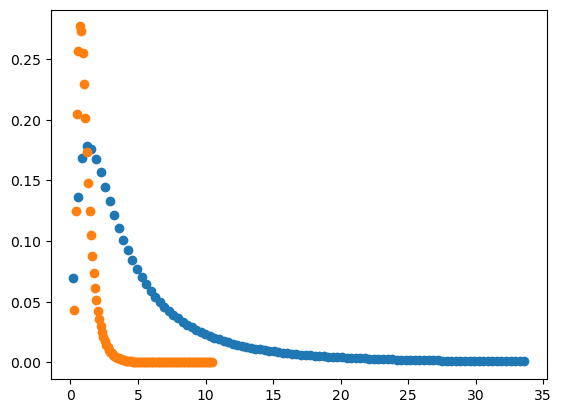

In [30]:
plt.scatter(x_shape,x_distr)
plt.scatter(x_shape_or,x_distr_or)

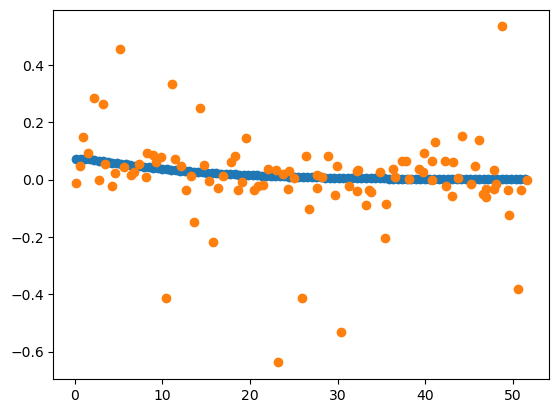

In [12]:
plt.scatter(xt.cpu().detach().numpy(),lab.cpu().detach().numpy())
plt.scatter(outputs[0].cpu().detach().numpy(),outputs[1].cpu().detach().numpy())

In [8]:
torch.save(model.state_dict(), 'weights_3_9_2')

In [7]:
dataset_test = CustomDataset(images3, coords_test)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)
model.eval()
running_loss2=0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        #labels= labels.to(device)
        #lab = torch.mean(lab, dim=(2,3)).squeeze()

        outp = model(inputs)  
        test_loss = criterion(outp, labels.to(device))
        running_loss2 += test_loss.item()
epoch_loss2 = running_loss2 / len(test_dataloader)
epoch_loss2

340231.74375

In [ ]:
# next(iter(dataloader))
ina.shape

In [ ]:
outp



In [ ]:
for i in range(672):
    print(torch.nan_to_num(xc_data[0:14,i]))

In [8]:
np_out = np.array(outp.cpu().detach())
np_out[np_out<=20]=np.nan
np_out.shape


(10, 2000, 2)

In [9]:
np_lab = np.array(labels.detach())
np_lab[np_lab==0]=np.nan


In [12]:
np_lab

array([[[360.78415, 335.69382],
        [      nan,       nan],
        [      nan,       nan],
        ...,
        [      nan,       nan],
        [      nan,       nan],
        [      nan,       nan]],

       [[377.5993 , 342.52182],
        [      nan,       nan],
        [      nan,       nan],
        ...,
        [      nan,       nan],
        [      nan,       nan],
        [      nan,       nan]],

       [[395.49115, 347.76654],
        [      nan,       nan],
        [      nan,       nan],
        ...,
        [      nan,       nan],
        [      nan,       nan],
        [      nan,       nan]],

       [[415.54092, 350.15506],
        [      nan,       nan],
        [      nan,       nan],
        ...,
        [      nan,       nan],
        [      nan,       nan],
        [      nan,       nan]]], dtype=float32)

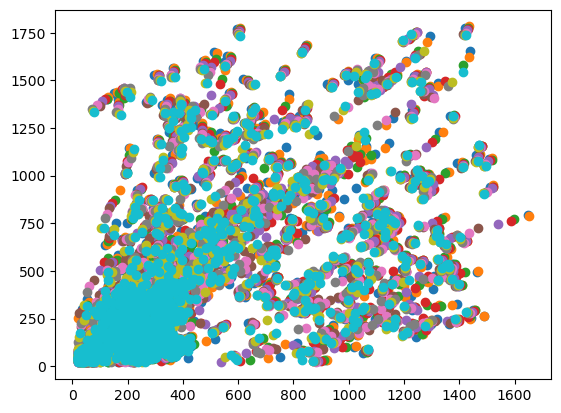

In [13]:
for i in range(np_out.shape[0]):
    plt.scatter(np_out[i,:,0],np_out[i,:,1])

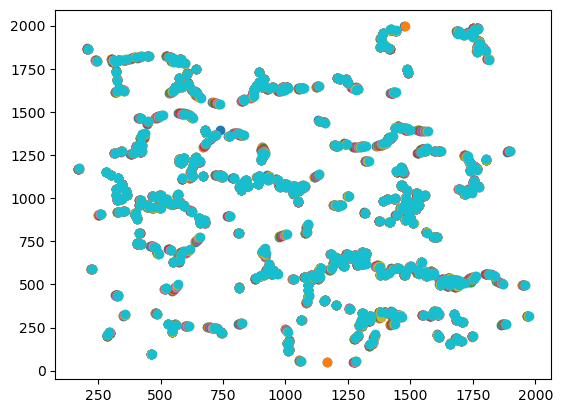

In [14]:
for i in range(np_lab.shape[0]):
    plt.scatter(np_lab[i,:,0],np_lab[i,:,1])

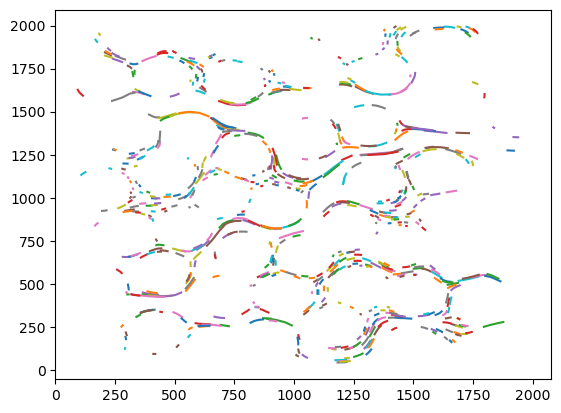

In [15]:
for i in range(np_lab.shape[1]):
    plt.plot(np_lab[:,i,0],np_lab[:,i,1])

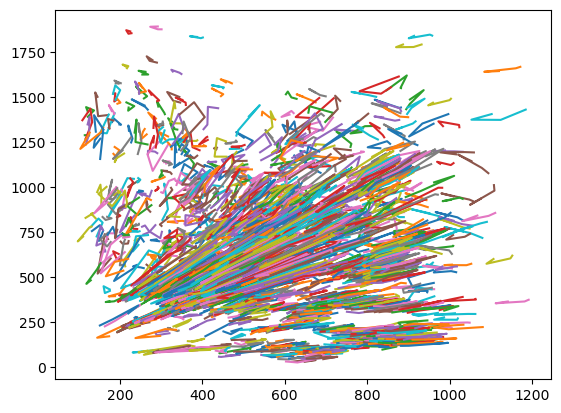

In [16]:
for i in range(np_out.shape[1]):
    plt.plot(np_out[:,i,0],np_out[:,i,1])

In [ ]:
plt.plot(np_lab[:,i,0],np_lab[:,i,1])
plt.plot(np_out[:,i,0],np_out[:,i,1])

In [ ]:
np_out[:,i,0]

In [ ]:
np_out[:,i,1]

In [ ]:
lab[:,0,0]